In [30]:
import cmb_utils
import numpy as np
import pyfftw
import pyfftw.interfaces.numpy_fft as fft
from scipy.interpolate import interp1d
from scipy import linalg as LA
import matplotlib.pyplot as plt

In [31]:
pix_width = 0.0015707
cmb_data = np.load('cmb_analysis_pset_data.npz')

In [32]:
for key in cmb_data.keys():
    print(key)

test_signal
test_white_noise
test_red_noise
test_x
test_y
data_small
x_small
y_small
data_large
x_large
y_large


In [33]:
cmb_data['test_red_noise'].shape

(65536,)

# 1. Map making

## 1.1 Operators

All steps in this section are already provided in the starter code (cmb_utils). Section 1.1 in the pset is rather an explanation for what the starter code (more speficially the NoisePointingModel class) does.

## 1.2 Estimating the time stream noise power spectrum

First, we choose a data set to be processed.

In [34]:
dt_test = cmb_data['test_signal'] + cmb_data['test_white_noise'] + cmb_data['test_red_noise'] # test data
x_test = np.round(cmb_data['test_x']/pix_width).astype(int) # x coordinates of the test data, starting with 0
y_test = np.round(cmb_data['test_y']/pix_width).astype(int) # y coordinates of the test data, starting with 0
nx_test = np.amax(x_test) + 1 # Map size in x direction (plus 1 counting the 0th index) 
ny_test = np.amax(y_test) + 1 # Map size in y direction (plus 1 counting the 0th index)
nt_test = len(x_test) # total number of data points

In [35]:
print(nx_test, ny_test, nt_test)

32 32 65536


1. FFT $d_t$ and divide by $\sqrt{n_t}$ to obtain $d_\omega$.

In [36]:
dt = dt_test
x = x_test
y = y_test
nx = nx_test
ny = ny_test
nt = nt_test

In [37]:
d_omega = fft.rfft(dt)/np.sqrt(nt) # fft with real data as input
omega = fft.rfftfreq(nt)*2*np.pi # angular frequencies

2. The quantity $d_\omega d_\omega^*$ is then a noisy estimate for $P_\eta(\omega)$.

In [38]:
P_eta_unbinned = d_omega*np.conjugate(d_omega)

/Users/ethanmarx/Library/Python/3.7/lib/python/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$P_\\eta$')

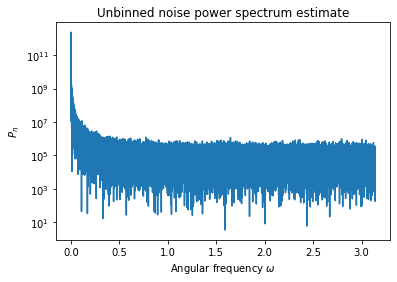

In [39]:
plt.plot(omega[:], P_eta_unbinned[:])
plt.title("Unbinned noise power spectrum estimate")
plt.yscale('log')
plt.xlabel(r'Angular frequency $\omega$')
plt.ylabel(r'$P_\eta$')

3. Accumulate the estimate over bins in $\omega$ to reduce uncertainty

In [44]:
n_omega = len(omega) # number of frequencies
bins = np.linspace(omega[0], omega[-1], num = int(n_omega/100), endpoint = True) # bin edges, each bin contains about 100 points
P_eta_binned = np.histogram(omega, bins, weights=P_eta_unbinned)[0]/np.histogram(omega, bins)[0]
bin_centers = np.array([(bins[i] + bins[i+1])/2 for i in range(len(bins) -1)])

/Users/ethanmarx/Library/Python/3.7/lib/python/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$P_\\eta$')

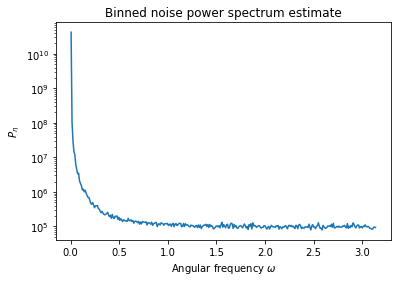

In [45]:
plt.plot(bin_centers[:], P_eta_binned[:])
plt.title("Binned noise power spectrum estimate")
plt.yscale('log')
plt.xlabel(r'Angular frequency $\omega$')
plt.ylabel(r'$P_\eta$')

4. Interpolate/extrapolate the result to any $\omega$.

In [48]:
# Before we interpolate, we have to add the first and last data point. Otherwise interpolator will return "out of range"
first = np.sum(P_eta_unbinned[0:20])/20 # estimate for P_eta at omega[0], 20 is arbitrarily chosen
last = np.sum(P_eta_unbinned[-20:])/20 # estimate for P_eta at omega[-1]
omega_for_interp = np.insert(np.append(bin_centers, omega[-1]), 0, omega[0])
P_eta_for_interp = np.insert(np.append(P_eta_binned, last), 0, first)

In [49]:
P_eta_interp = interp1d(omega_for_interp, P_eta_for_interp)
P_eta_final = P_eta_interp(omega) # use interpolator to get P_eta at orignial omegas but now it is much smoother

/Users/ethanmarx/Library/Python/3.7/lib/python/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$P_\\eta$')

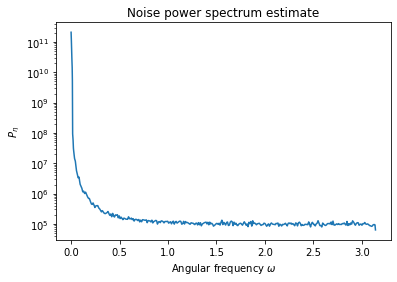

In [50]:
plt.plot(omega, P_eta_final)
plt.title("Noise power spectrum estimate")
plt.yscale('log')
plt.xlabel(r'Angular frequency $\omega$')
plt.ylabel(r'$P_\eta$')

## 1.3 Noise covariance inverse

Obtain $C_N^{-1}$

In [51]:
model_test = cmb_utils.NoisePointingModel(x_test, y_test, nx_test, ny_test, P_eta_final)
CN_inv_test = model_test.map_noise_inv()
CN_inv_test.shape

x-index 0
x-index 1
x-index 2
x-index 3
x-index 4
x-index 5
x-index 6
x-index 7
x-index 8
x-index 9
x-index 10
x-index 11
x-index 12
x-index 13
x-index 14
x-index 15
x-index 16
x-index 17
x-index 18
x-index 19
x-index 20
x-index 21
x-index 22
x-index 23
x-index 24
x-index 25
x-index 26
x-index 27
x-index 28
x-index 29
x-index 30
x-index 31


(32, 32, 32, 32)

Reshape $C_N^{-1}$ into a 2D matrix.

In [57]:
CN_inv_test_reshape = np.reshape(CN_inv_test, (nx*ny, nx*ny))
CN_inv_test_reshape.shape

(1024, 1024)

Invert to obtain $C_N$.

In [58]:
CN_test = LA.inv(CN_inv_test_reshape)

Text(0.5, 1.0, '$C_N^{-1}*C_N$')

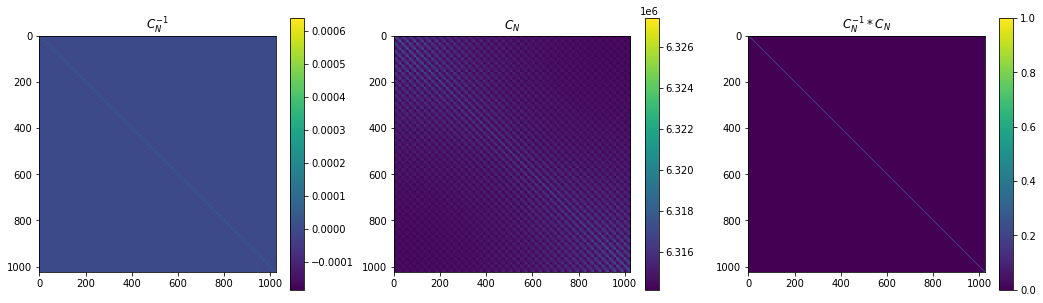

In [59]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.imshow(CN_inv_test_reshape)
plt.colorbar()
plt.title(r'$C_N^{-1}$')
plt.subplot(132)
plt.imshow(CN_test)
plt.colorbar()
plt.title(r'$C_N$')
plt.subplot(133)
plt.imshow(np.dot(CN_test,CN_inv_test_reshape))
plt.colorbar()
plt.title(r'$C_N^{-1}*C_N$')

Get the signal estimate with D&S (14.30)

In [62]:
N_inv_d_test = model_test.apply_noise_weights(dt)
out = np.zeros((nx, ny), dtype=float)
P_T_N_inv_d_test = model_test.grid_data(N_inv_d_test, out)

In [63]:
P_T_N_inv_d_test.shape

(32, 32)

In [64]:
s_hat_test = np.dot(CN_test, P_T_N_inv_d_test.flatten())
s_hat_test = np.reshape(s_hat_test, (nx, ny))

Text(0.5, 1.0, 'Test data map estimate')

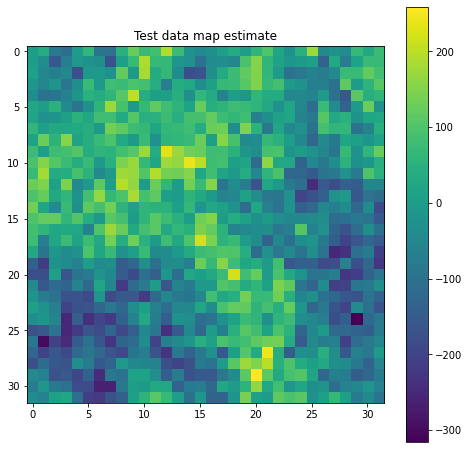

In [65]:
plt.figure(figsize=(8,8))
plt.imshow(s_hat_test)
plt.colorbar()
plt.title('Test data map estimate')

# 1.4 Testing

Check the result with test signal only and construct the map with D&S (14.33)

In [66]:
dt_signal = cmb_data['test_signal']

In [67]:
s_hat_test_signal = np.zeros((nx, ny), dtype=float)
m = np.zeros((nx, ny), dtype=float)
np.add.at(s_hat_test_signal, (x, y), dt_signal)
np.add.at(m, (x, y), 1)
s_hat_test_signal = s_hat_test_signal/m

Text(0.5, 1.0, 'Test signal-only map')

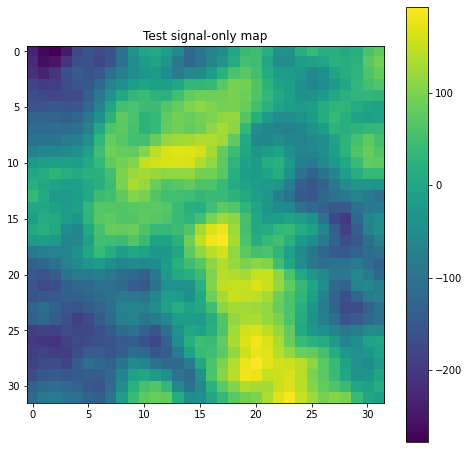

In [68]:
plt.figure(figsize=(8,8))
plt.imshow(s_hat_test_signal)
plt.colorbar()
plt.title('Test signal-only map')

Text(0.5, 1.0, 'Noise in test data map estimate')

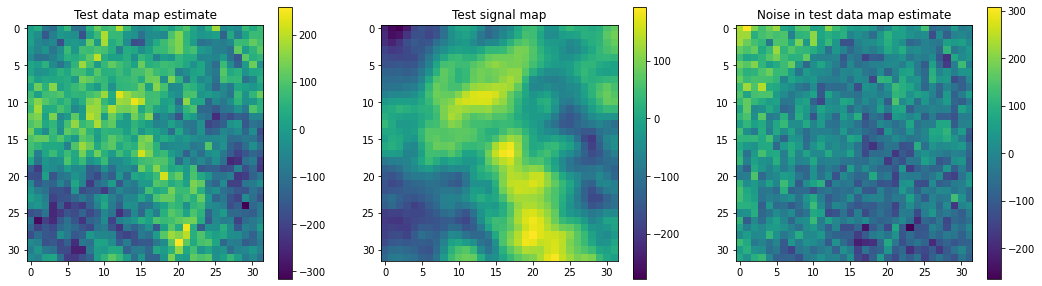

In [69]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.imshow(s_hat_test)
plt.colorbar()
plt.title('Test data map estimate')
plt.subplot(132)
plt.imshow(s_hat_test_signal)
plt.colorbar()
plt.title('Test signal map')
plt.subplot(133)
plt.imshow(s_hat_test - s_hat_test_signal)
plt.colorbar()
plt.title('Noise in test data map estimate')

# 2. Power Spectrum estimation

In this section, we are looking to estimate the band powers, $c^\alpha$

Applying Dodelson 1st edition eqn 11.94 in this context gives:
    
\begin{equation}
\hat{c^\alpha} = c^\alpha_{0} + F^{-1}_{\alpha \beta}\frac{s C^{-1} C_{,\beta} C^{-1} s - Tr(C^{-1} C_{,\beta})}{2}
\end{equation}

where 
\begin{equation}
F_{\alpha \beta} =  \frac{Tr(C_{, \alpha} C^{-1} C_{,\beta} C^{-1})}{2}
\end{equation}

\begin{equation}
C = C_{S} + C_{N}
\end{equation}

$s$ is our signal map created in the previous part, and $c^\alpha_{0}$ is calculated from a fiducial model, in our case, CAMB


We have already calculated $C_{N}$ in the previous part, we just need $C_{S}$, which enters into the equation for $\hat{c^\alpha}$ in two parts:

1. $C^{-1}$
2. $C_{,\alpha}$

## 2.1 Signal Covariance Matrix

To account for $C_{S}$ in the calculation of $C^{-1}$, we will use our fiducial cosmology to fix $C_{l}$ and apply:

\begin{equation}
C_{S}= \bar{T}^{2} \omega(\lvert \theta_{i} - \theta_{j} \rvert, \lambda_{\alpha})
\end{equation}

with 

\begin{equation}
\omega(\theta, \lambda_{alpha}) = \int_{0}^{\infty} \frac{dl}{2\pi} C_{l}(\lambda_{\alpha})J_{0}(l\theta)
\end{equation}

## 2.2 Band Powers

To account for $C_{S}$ in the calculation of $C_{,\alpha}$ we will use band powers $c^{\alpha}$  as our parameters:

\begin{equation}
C_{l}^{obs} \approx \sum_{\alpha}c^{\alpha}E_{\alpha}(l)
\end{equation}

where 
\begin{equation}
E_{\alpha}(l) = 
\begin{cases}  
1 & l_{\alpha}^{low} \leq l < l_{\alpha + 1}^{low} \\
0 & otherwise \\
\end{cases}
\end{equation}

It can then be shown that 
\begin{equation}
C_{,\alpha} = \int_{0}^{\infty} \frac{dl}{2\pi} E_{\alpha}(l)J_{0}(l\theta)
\end{equation}